# Estimation of time-varying volatility using Levy distribution (large $n$)

In [1]:
#Import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import levy
from scipy.special import erfc, erfinv, gamma, gammainc
import math
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
import time

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line

# scipy for qq plots
import statsmodels.api as sm
import scipy.stats as stats

/Users/kotakikuchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/kotakikuchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# some pandas option setting
pd.options.display.max_rows = 150

In [3]:
# python plot options
plt.rcParams['figure.dpi'] = 500

In [4]:
sys.path.append('../../tools')
import tools

In [5]:
importlib.reload(tools)

<module 'tools' from '../../tools/tools.py'>

## Estimating Time-varying Volatility

#### general set-up

In [25]:
# Paramater for t (here store as t)

ts  = np.array([0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])


S = np.array([1000])
n = np.array([500000])

# Color for and types for graph
colors = ['r','g','b','black']
types = ['solid','dashed','dashdot','dotted']

In [26]:
a_ns = [
    8*(Ns)**(1/1)/(max(ts) - min(ts)),
    8*(Ns)**(1/2)/(max(ts) - min(ts)),
    8*(Ns)**(1/4)/(max(ts) - min(ts))
]

In [27]:
deltas = (3/2)*np.array(a_ns)

In [28]:
deltas

array([[6.00000600e+06],
       [8.48528986e+03],
       [3.19098073e+02]])

### $c$ = $1.4*10**(-5)$

#### set-up


In [29]:
# Paramater for levy distribution
c = 1.4*10**(-5)

# g
g = np.sqrt(c)

# True Levy distribution
f = levy.pdf(ts,  scale = c)
F = levy.cdf(ts,  scale = c)

sigma = tools.sigma_hat_t(f, F, g) 

#### Estimation

**Estimation of f and F**

- However, let a_n change depending on t
    - $10^{-6} \leq t < 10^{-3}$ : $a_n = \frac{8 \times n}{C}$
    - $10^{-3} \leq t < 10^{-1}$ : $a_n = \frac{8 \times n^{\frac{1}{2}}}{C}$
    - $10^{-1} \leq t = \leq 10^{+1}$ : $a_n = \frac{8 \times n^{\frac{1}{4}}}{C}$

In [33]:
### for different number of iterations
f_hats_Ns  = []
F_hats_Ns = []
sigma_hats_Ns = []

for n_i, n in zip(range(0, len(Ns)), Ns):

    # start time for the current t
    start_time = time.time()

    # all sample, 
    ### maybe do not need the _s??
    f_hats_t = []
    F_hats_t = []
    sigma_hats_t = []

    # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        f_hats_s = []
        F_hats_s = []
        sigma_hats_s = []
        
        if t < 0.001:
            n_s = 0
        elif (t <0.1) & (t>=0.001):
            n_s = 1
        else:
            n_s = 2
        
        
        # for differernt iterations
        for s in range(0, S[0]):

            # generate random sample
            t_g_w = levy.rvs(scale = c, size = n)

            # estimate f_hat and F_hat 
            f_hat = tools.f_hat_t(t, t_g_w, deltas[n_s][n_i])
            F_hat = tools.F_hat_t(t, t_g_w, deltas[n_s][n_i])   
    
            # store the estimates for this iteration
            f_hats_s.append(f_hat)
            F_hats_s.append(F_hat)
        
         # calculate sigma_hats
        f_hats_t.append(np.array(f_hats_s))
        F_hats_t.append(np.array(F_hats_s))
        
    
    # append to 
    f_hats_Ns.append(f_hats_t)
    F_hats_Ns.append(F_hats_t)
    igma_hats_t = np.array(tools.sigma_hat_t(f_hats_t, F_hats_t, g))
    sigma_hats_Ns.append(sigma_hats_t)

    # print how much time it took to calculate for the current number of iterations
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for S = {S[0]}, n = {n}")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

$\widehat{CV}_g^n = \sum_{k=0}^{M_n-1} \widehat{k(\sigma_{T_k^n,f}^2)^n} \Delta_n.$

In [87]:
def k(x):
    return x**2

def dkdx(x):
    return 2*x
    

In [88]:
# central limit theorem and instantaneous volativlity
clts_Ns = []
sigma_hats_Ns = []

# infeasible and feasible Z statistics related to the instantaneous variance estimator
z_infs = []
z_feas = []

# infeasible and feasible Z statistics related to the functional of variance estimator
z_func_infs = []
z_func_feas = []

# # cumulative version
# z_cv_infs_Ns = []
# z_cv_feas_Ns = []

for n_i, n in zip(range(0, len(Ns)), Ns):

    # f and F hats
    f_hats_n = f_hats_Ns[n_i]
    F_hats_n = F_hats_Ns[n_i]
    sigma_hats_n = []
    
    z_infs_n = []
    z_feas_n = []
    
    z_func_infs_n = []
    z_func_feas_n = []
    
     # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        f_hats_t = f_hats_n[t_i]
        F_hats_t = F_hats_n[t_i]
        
        if t < 0.001:
            n_s = 0
        elif t <0.1 & t >= 0.001:
            n_s = 1
        else:
            n_s = 2
            

        ### calculte sigma_hats
        sigma_hats_t = np.array(tools.sigma_hat_t(f_hats_t, F_hats_t, g))
        sigma_hats_n.append(sigma_hats_t)

        ### calculating different statistics
        # z-stats of instantaneous volatility
        z_inf_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F[t_i],g),g)**2)/f[t_i]))*(sigma_hats_t - sigma[t_i])
        z_fea_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F_hats_t,g),g)**2)/f_hats_t))*(sigma_hats_t - sigma[t_i])
    
        z_infs_n.append(z_inf_t)
        z_feas_n.append(z_fea_t)
    
        # z-stats on functional of instataneous volatility
        z_func_inf_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F[t_i],g),g)**2)/((dkdx(sigma[t_i])**2)*f[t_i])))*(k(sigma_hats_t) - k(sigma[t_i]))
        z_func_fea_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F_hats_t,g),g)**2)/((dkdx(sigma_hats_t)**2)*f_hats_t)))*(k(sigma_hats_t) - k(sigma[t_i]))
    
        z_func_infs_n.append(z_func_inf_t)
        z_func_feas_n.append(z_func_fea_t)
    
    z_infs.append(z_infs_n)
    z_feas.append(z_feas_n)
    
    z_func_infs.append(z_func_infs_n)
    z_func_feas.append(z_func_feas_n)

    sigma_hats_Ns.append(sigma_hats_n)

<ipython-input-88-ae44f12fe645>:49: RuntimeWarning: divide by zero encountered in true_divide
  z_fea_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F_hats_t,g),g)**2)/f_hats_t))*(sigma_hats_t - sigma[t_i])
<ipython-input-88-ae44f12fe645>:56: RuntimeWarning: divide by zero encountered in true_divide
  z_func_fea_t = np.sqrt((n/a_ns[n_s][n_i])*((tools.fgW(tools.PgW_inv(F_hats_t,g),g)**2)/((dkdx(sigma_hats_t)**2)*f_hats_t)))*(k(sigma_hats_t) - k(sigma[t_i]))


### Summary Stats

#### Estimators, choses $a_n$ that seem to be working

In [89]:
f_hats_an = []
F_hats_an = []
sigma_hats_an = []
n = 100
for an_i, an in zip(range(0, len(a_ns[n_s])), a_ns[n_s]):
    
    f_hats = []
    F_hats = []
    sigma_hats = []
    
    for s in range(0, S[0]):
        # generate random sample
        t_g_w = levy.rvs(scale = c, size = n)

        # estimate f_hat and F_hat 
        f_hat = tools.f_hat_t(t, t_g_w, deltas[n_s][an_i])
        F_hat = tools.F_hat_t(t, t_g_w, deltas[n_s][an_i])  
        sigma_hat = tools.sigma_hat_t(f_hat, F_hat, g)

        f_hats.append(f_hat)
        F_hats.append(F_hat)
        sigma_hats.append(sigma_hat)
        
    f_hats_an.append(f_hats)
    F_hats_an.append(F_hats)
    sigma_hats_an.append(sigma_hats)
        

In [100]:
summary_stats = [np.nanmean, np.nanstd, 0.05, 0.95]
# in indices, add sample size and etc
summaries = []

## access estimation for simulation with a particular number of of iteration
for an_i, an in zip(range(0, len(a_ns[n_s])), a_ns[n_s]):

    ### access estimations for simulations with a particular number of iteration
    f_hats_n = f_hats_an[an_i]
    F_hats_n = F_hats_an[an_i]
    sigma_hats_n = sigma_hats_an[an_i]


    ### calculate stats
    f_stats = tools.estimation_summary(f_hats_n, summary_stats, f[t_i],  rounding = 10)
    F_stats = tools.estimation_summary(F_hats_n, summary_stats, F[t_i], rounding = 10)
    sigma_stats = tools.estimation_summary(sigma_hats_n, summary_stats, F[t_i], rounding = 10)
    
    # ideal number
    f_stats = np.insert(f_stats, 0, f[t_i])
    F_stats = np.insert(F_stats, 0, F[t_i])
    sigma_stats = np.insert(sigma_stats, 0, sigma[t_i])

    
    summary_n = pd.DataFrame([f_stats, F_stats, sigma_stats],
                         columns = ['Target','Mean','Std', '5.0\%', '95\%'],
                         index = [np.tile(S[0], 3), np.tile(n, 3), np.tile(t, 3),np.tile((3/2)*an,3),
                                  ['$\widehat{f}_n(t)$',
                                    '$\widehat{F}_n(t)$',
                                    '$\widehat{\sigma}_{t, n}^f$']])



    summary_n.index.set_names(['S','n', 't','$\delta$','Statistics'], inplace = True)

    # store the summary
    summaries.append(summary_n)


In [101]:
pd.concat(summaries)

Target  \
S    n       t        $\delta$     Statistics                                  
1000 1000000 0.000003 2.529822e+09 $\widehat{f}_n(t)$           22963.576099   
                                   $\widehat{F}_n(t)$               0.017960   
                                   $\widehat{\sigma}_{t, n}^f$      1.000000   
                      3.577709e+09 $\widehat{f}_n(t)$           22963.576099   
                                   $\widehat{F}_n(t)$               0.017960   
                                   $\widehat{\sigma}_{t, n}^f$      1.000000   
                      5.656854e+09 $\widehat{f}_n(t)$           22963.576099   
                                   $\widehat{F}_n(t)$               0.017960   
                                   $\widehat{\sigma}_{t, n}^f$      1.000000   
                      8.000000e+09 $\widehat{f}_n(t)$           22963.576099   
                                   $\widehat{F}_n(t)$               0.017960   
                                   $\widehat{\sigma}_{t, n}^f$      1.000000   

                                                                       Mean  \
S    n       t        $\delta$     Statistics                                 
1000 1000000 0.000003 2.529822e+09 $\widehat{f}_n(t)$           2953.008798   
                                   $\widehat{F}_n(t)$              0.018250   
                                   $\widehat{\sigma}_{t, n}^f$     0.106746   
                      3.577709e+09 $\widehat{f}_n(t)$              0.000000   
                                   $\widehat{F}_n(t)$              0.017710   
                                   $\widehat{\sigma}_{t, n}^f$     0.000000   
                      5.656854e+09 $\widehat{f}_n(t)$              0.000000   
                                   $\widehat{F}_n(t)$              0.017830   
                                   $\widehat{\sigma}_{t, n}^f$     0.000000   
                      8.000000e+09 $\widehat{f}_n(t)$              0.000000   
                                   $\widehat{F}_n(t)$              0.017400   
                                   $\widehat{\sigma}_{t, n}^f$     0.000000   

                                                                         Std  \
S    n       t        $\delta$     Statistics                                  
1000 1000000 0.000003 2.529822e+09 $\widehat{f}_n(t)$           93335.634685   
                                   $\widehat{F}_n(t)$               0.013713   
                                   $\widehat{\sigma}_{t, n}^f$      3.373919   
                      3.577709e+09 $\widehat{f}_n(t)$               0.000000   
                                   $\widehat{F}_n(t)$               0.013079   
                                   $\widehat{\sigma}_{t, n}^f$      0.000000   
                      5.656854e+09 $\widehat{f}_n(t)$               0.000000   
                                   $\widehat{F}_n(t)$               0.013733   
                                   $\widehat{\sigma}_{t, n}^f$      0.000000   
                      8.000000e+09 $\widehat{f}_n(t)$               0.000000   
                                   $\widehat{F}_n(t)$               0.012878   
                                   $\widehat{\sigma}_{t, n}^f$      0.000000   

                                                                5.0\%  95\%  
S    n       t        $\delta$     Statistics                                
1000 1000000 0.000003 2.529822e+09 $\widehat{f}_n(t)$             0.0  0.00  
                                   $\widehat{F}_n(t)$             0.0  0.04  
                                   $\widehat{\sigma}_{t, n}^f$    0.0  0.00  
                      3.577709e+09 $\widehat{f}_n(t)$             0.0  0.00  
                                   $\widehat{F}_n(t)$             0.0  0.04  
                                   $\widehat{\sigma}_{t, n}^f$    0.0  0.00  
                      5.656854e+09 $\widehat{f}_n(t)$             0.0  0.00  
                   

In [103]:
print(pd.concat(summaries).to_latex(
                        caption = r'Summary statistics for Levy Distribution using different $\alpha_n$',
                        float_format="%.3f",
                        position = 'H',
                        escape=False,
                        longtable = True))

\begin{longtable}[H]{lllllrrrrr}
\caption{Summary statistics for Levy Distribution using different $\alpha_n$}\\
\toprule
     &         &          &              &                             &    Target &     Mean &       Std &  5.0\% &  95\% \\
S & n & t & $\delta$ & Statistics &           &          &           &        &       \\
\midrule
\endfirsthead
\caption[]{Summary statistics for Levy Distribution using different $\alpha_n$} \\
\toprule
     &         &          &              &                             &    Target &     Mean &       Std &  5.0\% &  95\% \\
S & n & t & $\delta$ & Statistics &           &          &           &        &       \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1000 & 1000000 & 0.000003 & 2.529822e+09 & $\widehat{f}_n(t)$ & 22963.576 & 2953.009 & 93335.635 &  0.000 & 0.000 \\
     &         &          &              & $\widehat{F}_n(t)$ &     0.018 &    0.018 &     0.014

<ipython-input-103-92b06b49c386>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).to_latex(


#### Estimators

In [104]:
summary_stats = [np.nanmean, np.nanstd, 'mse',0.05, 0.95]
# in indices, add sample size and etc
summaries = []

## access estimation for simulation with a particular number of of iteration
for n_i, n in zip(range(0, len(Ns)), Ns):

    ### access estimations for simulations with a particular number of iteration
    f_hats_n = f_hats_Ns[n_i]
    F_hats_n = F_hats_Ns[n_i]
    sigma_hats_n = sigma_hats_Ns[n_i]
    summary_n = []
    
    # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        f_hats_t = f_hats_n[t_i]
        F_hats_t = F_hats_n[t_i]
        sigma_hats_t = sigma_hats_n[t_i]
    
        ### calculate stats
        f_stats = tools.estimation_summary(f_hats_t, summary_stats, f[t_i],  rounding = 10)
        F_stats = tools.estimation_summary(F_hats_t, summary_stats, F[t_i], rounding = 10)
        sigma_stats = tools.estimation_summary(sigma_hats_t, summary_stats, F[t_i], rounding = 10)
    
        f_stats = np.insert(f_stats, 0, f[t_i])
        F_stats = np.insert(F_stats, 0, F[t_i])
        sigma_stats = np.insert(sigma_stats, 0, sigma[t_i])

    
        summary_t = pd.DataFrame([f_stats, F_stats, sigma_stats],
                         columns = ['Target','Mean','Std', 'MSE','5.0\%', '95\%'],
                         index = [np.tile(S[0], 3), np.tile(n, 3), np.tile(t, 3), 
                                  ['$\widehat{f}_n(t)$',
                                    '$\widehat{F}_n(t)$',
                                    '$\widehat{\sigma}_{t, n}^f$']])
        
        summary_t.index.set_names(['S','n', 't', 'Statistics'], inplace = True)
        
        summary_n.append(summary_t)

    # store the summary
    summary_n = pd.concat(summary_n)
    summaries.append(summary_n)


In [105]:
pd.concat(summaries)

Target          Mean  \
S    n       t        Statistics                                                
1000 100000  0.000001 $\widehat{f}_n(t)$            1361.171071   1383.578829   
                      $\widehat{F}_n(t)$               0.000183      0.000183   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.010752   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23599.500858   
                      $\widehat{F}_n(t)$               0.017960      0.017952   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.028064   
     200000  0.000001 $\widehat{f}_n(t)$            1361.171071   1094.964168   
                      $\widehat{F}_n(t)$               0.000183      0.000182   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.811108   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23781.847593   
                      $\widehat{F}_n(t)$               0.017960      0.017983   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.034915   
     500000  0.000001 $\widehat{f}_n(t)$            1361.171071   1402.767855   
                      $\widehat{F}_n(t)$               0.000183      0.000182   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.034226   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23511.723966   
                      $\widehat{F}_n(t)$               0.017960      0.017958   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.023984   
     1000000 0.000001 $\widehat{f}_n(t)$            1361.171071   1229.405827   
                      $\widehat{F}_n(t)$               0.000183      0.000183   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.906693   
             0.000003 $\widehat{f}_n(t)$           22963.576099  22837.617944   
                      $\widehat{F}_n(t)$               0.017960      0.017958   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.994686   

                                                            Std           MSE  \
S    n       t        Statistics                                                
1000 100000  0.000001 $\widehat{f}_n(t)$            4676.338513  5.021077e+02   
                      $\widehat{F}_n(t)$               0.000041  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      3.472233  1.021250e+00   
             0.000003 $\widehat{f}_n(t)$           20596.859511  4.044003e+05   
                      $\widehat{F}_n(t)$               0.000410  1.000000e-10   
                      $\widehat{\sigma}_{t, n}^f$      0.897685  1.020310e+00   
     200000  0.000001 $\widehat{f}_n(t)$            3413.189775  7.086611e+04   
                      $\widehat{F}_n(t)$               0.000030  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      2.546687  6.575993e-01   
             0.000003 $\widehat{f}_n(t)$           16812.295171  6.695682e+05   
                      $\widehat{F}_n(t)$               0.000303  5.000000e-10   
                      $\widehat{\sigma}_{t, n}^f$      0.731050  1.034196e+00   
     500000  0.000001 $\widehat{f}_n(t)$            3309.878778  1.730292e+03   
                      $\widehat{F}_n(t)$               0.000020  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      2.445995  1.069245e+00   
             0.000003 $\widehat{f}_n(t)$           13259.617756  3.004661e+05   
                      $\widehat{F}_n(t)$               0.000184  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      0.577669  1.012083e+00   
     1000000 0.000001 $\widehat{f}_n(t)$            2411.845976  1.736208e+04   
                      $\widehat{F}_n(t)$               0.000014  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      1.785186  8.217615e-01   
             0.000003 $\widehat{f}_n(t)$           11063.269884  1.586546e+04   
      

#### Z - Stats

In [106]:
summary_stats = [np.nanmean, np.nanstd, 0.05, 0.95]
#  'mse'
# in indices, add sample size and etc
summaries = []

## access estimation for simulation with a particular number of of iteration
for n_i, n in zip(range(0, len(Ns)), Ns):

    ### access estimations for simulations with a particular number of iteration
    f_hats_n = f_hats_Ns[n_i]
    F_hats_n = F_hats_Ns[n_i]
    sigma_hats_n = sigma_hats_Ns[n_i]
    summary_n = []
    
    # feasible and infeasible statistics
    z_infs_n = z_infs[n_i]
    z_feas_n = z_feas[n_i]

    
    # functional
    z_func_infs_n = z_func_infs[n_i]
    z_func_feas_n = z_func_feas[n_i]


    summaries_n = []
    
    # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        # for each t 
        f_hats_t = f_hats_n[t_i]
        F_hats_t = F_hats_n[t_i]
        sigma_hats_t = sigma_hats_n[t_i]
        
        z_infs_t = z_infs_n[t_i]
        z_infs_t = z_infs_t[~np.isinf(z_infs_t)]
        z_feas_t = z_feas_n[t_i]
        z_feas_t = z_feas_t[~np.isinf(z_feas_t)]
        
        z_func_infs_t = z_func_infs_n[t_i]
        z_func_infs_t = z_func_infs_t[~np.isinf(z_func_infs_t)]
        z_func_feas_t = z_func_feas_n[t_i]
        z_func_feas_t = z_func_feas_t[~np.isinf(z_func_feas_t)]

        ### calculate stats
        f_stats_t = tools.estimation_summary(f_hats_t, summary_stats, f[t_i],  rounding = 10)
        F_stats_t = tools.estimation_summary(F_hats_t, summary_stats, F[t_i], rounding = 10)
        sigma_stats_t = tools.estimation_summary(sigma_hats_t, summary_stats, sigma[t_i], rounding = 10)

        # infeasible and feasible
        z_inf_stats_t = tools.estimation_summary(z_infs_t, summary_stats, 0,  rounding = 10)
        z_feas_stats_t = tools.estimation_summary(z_feas_t, summary_stats, 0,  rounding = 10)

        # infeasible and feasible, functional vesion
        z_func_inf_stats_t = tools.estimation_summary(z_func_infs_t, summary_stats, 0,  rounding = 10)
        z_func_feas_stats_t = tools.estimation_summary(z_func_feas_t, summary_stats, 0,  rounding = 10)

 

        # create a dataframe
        # z_cv_inf_stats, z_cv_feas_stats
        # '$Z_{T_-,T_+}^{CV,inf}$', '$Z_{T_-,T_+}^{CV,feas}$'
        summary_t = pd.DataFrame([z_inf_stats_t, 
                                  z_feas_stats_t, 
                                  z_func_inf_stats_t, 
                                  z_func_feas_stats_t
                                 ],
                                 # 'MSE'
                             columns = ['Mean', 'Std','5.0\%', '95\%'],
                             index = [np.tile(S[0], 4), np.tile(n, 4), np.tile(t, 4), 
                                      ['$Z_{t}^{\sigma^2_f,inf}$',
                                        '$Z_{t}^{\sigma^2_f,feas}$',
                                        '$Z_{t}^{k(\sigma^2_f),inf}$',
                                        '$Z_{t}^{k(\sigma^2_f),feas}$',
                                          ]])
        
        summary_t.index.set_names(['S','n', 't', 'Statistics'], inplace = True)
        
        summary_n.append(summary_t)
        
        
    
    summary_n = pd.concat(summary_n)
    # store the summary
    summaries.append(summary_n)




In [107]:
pd.concat(summaries).sort_index(level = 't')

Mean         Std  \
S    n       t        Statistics                                            
1000 100000  0.000001 $Z_{t}^{\sigma^2_f,feas}$      0.711265    0.376495   
                      $Z_{t}^{\sigma^2_f,inf}$       0.003054    0.986429   
                      $Z_{t}^{k(\sigma^2_f),feas}$   0.290717    1.088107   
                      $Z_{t}^{k(\sigma^2_f),inf}$    1.715627    8.036917   
     200000  0.000001 $Z_{t}^{\sigma^2_f,feas}$      0.614684    0.377282   
                      $Z_{t}^{\sigma^2_f,inf}$      -0.063816    0.860380   
                      $Z_{t}^{k(\sigma^2_f),feas}$   0.327348    0.379577   
                      $Z_{t}^{k(\sigma^2_f),inf}$    1.037770    4.704452   
     500000  0.000001 $Z_{t}^{\sigma^2_f,feas}$      0.595306    0.488611   
                      $Z_{t}^{\sigma^2_f,inf}$       0.014540    1.039094   
                      $Z_{t}^{k(\sigma^2_f),feas}$   0.119739    2.963861   
                      $Z_{t}^{k(\sigma^2_f),inf}$    1.285598    4.947206   
     1000000 0.000001 $Z_{t}^{\sigma^2_f,feas}$      0.415630    0.812947   
                      $Z_{t}^{\sigma^2_f,inf}$      -0.047138    0.901863   
                      $Z_{t}^{k(\sigma^2_f),feas}$  -4.636448   71.255796   
                      $Z_{t}^{k(\sigma^2_f),inf}$    0.760058    2.622198   
     100000  0.000003 $Z_{t}^{\sigma^2_f,feas}$     -0.166254    1.415352   
                      $Z_{t}^{\sigma^2_f,inf}$       0.032747    1.047477   
                      $Z_{t}^{k(\sigma^2_f),feas}$  -4.938026   53.903534   
                      $Z_{t}^{k(\sigma^2_f),inf}$    0.503359    1.670264   
     200000  0.000003 $Z_{t}^{\sigma^2_f,feas}$     -0.357826    2.234288   
                      $Z_{t}^{\sigma^2_f,inf}$       0.048449    1.014436   
                      $Z_{t}^{k(\sigma^2_f),feas}$ -27.741719  477.792839   
                      $Z_{t}^{k(\sigma^2_f),inf}$    0.420097    1.425731   
     500000  0.000003 $Z_{t}^{\sigma^2_f,feas}$     -0.348881    1.731241   
                      $Z_{t}^{\sigma^2_f,inf}$       0.041849    1.007958   
                      $Z_{t}^{k(\sigma^2_f),feas}$  -5.548144   89.291668   
                      $Z_{t}^{k(\sigma^2_f),inf}$    0.333484    1.284963   
     1000000 0.000003 $Z_{t}^{\sigma^2_f,feas}$     -0.327484    1.378514   
                      $Z_{t}^{\sigma^2_f,inf}$      -0.011027    1.000233   
                      $Z_{t}^{k(\sigma^2_f),feas}$  -1.596976   11.982774   
                      $Z_{t}^{k(\sigma^2_f),inf}$    0.230077    1.174780   

                                                       5.0\%       95\%  
S    n       t        Statistics                                         
1000 100000  0.000001 $Z_{t}^{\sigma^2_f,feas}$     0.102761   1.132236  
                      $Z_{t}^{\sigma^2_f,inf}$     -0.284091   2.426693  
                      $Z_{t}^{k(\sigma^2_f),feas}$  0.088157   0.597661  
                      $Z_{t}^{k(\sigma^2_f),inf}$  -0.142045  12.791415  
     200000  0.000001 $Z_{t}^{\sigma^2_f,feas}$     0.029819   1.101088  
                      $Z_{t}^{\sigma^2_f,inf}$     -0.337843   2.256703  
                      $Z_{t}^{k(\sigma^2_f),feas}$  0.028493   0.596049  
                      $Z_{t}^{k(\sigma^2_f),inf}$  -0.168921   9.793933  
     500000  0.000001 $Z_{t}^{\sigma^2_f,feas}$    -0.129004   1.258252  
                      $Z_{t}^{\sigma^2_f,inf}$     -0.424815   2.490487  
                      $Z_{t}^{k(\sigma^2_f),feas}$ -0.152997   0.686124  
                      $Z_{t}^{k(\sigma^2_f),inf}$  -0.212407   9.790770  
     1000000 0.000001 $Z_{t}^{\sigma^2_f,feas}$    -0.698395   1.044541  
                      $Z_{t}^{\sigma^2_f,inf}$     -0.505193   2.115231  
                      $Z_{t}^{k(\sigma^2_f),feas}$ -1.685812   0.607393  
                      $Z_{t}^{k(\sigma^2_f),inf}$  -0.252596   6.543446  
     100000  0.000003 $Z_{t}^{\sigma^2_f,feas}$    -2.335452   1.269805  
                      $Z_{t}^{\s

In [108]:
z_stats_summary = pd.concat(summaries)

In [109]:
for t in ts:
    
    z_stats_summary_t = z_stats_summary[z_stats_summary.index.get_level_values('t') == t]
    
    print(z_stats_summary_t.to_latex(
                        caption = f'Summary statistics for Levy Distribution with large $n$ at $t = {t}$',
                        float_format="%.3f",
                        position = 'H',
                        escape=False,
                        longtable = True))

\begin{longtable}[H]{llllrrrr}
\caption{Summary statistics for Levy Distribution with large $n$ at $t = 1e-06$}\\
\toprule
     &         &          &                              &   Mean &    Std &  5.0\% &   95\% \\
S & n & t & Statistics &        &        &        &        \\
\midrule
\endfirsthead
\caption[]{Summary statistics for Levy Distribution with large $n$ at $t = 1e-06$} \\
\toprule
     &         &          &                              &   Mean &    Std &  5.0\% &   95\% \\
S & n & t & Statistics &        &        &        &        \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1000 & 100000  & 0.000001 & $Z_{t}^{\sigma^2_f,inf}$ &  0.003 &  0.986 & -0.284 &  2.427 \\
     &         &          & $Z_{t}^{\sigma^2_f,feas}$ &  0.711 &  0.376 &  0.103 &  1.132 \\
     &         &          & $Z_{t}^{k(\sigma^2_f),inf}$ &  1.716 &  8.037 & -0.142 & 12.791 \\
     &         &          & $Z_{t}^{k(\sigma

<ipython-input-109-26e168f50750>:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z_stats_summary_t.to_latex(


### Plots

$$ Z_{t}^{\sigma^2_f,inf} := \sqrt{\frac{n}{\alpha_n} \frac{f_g^W((P_g^W)^{-1}(F(t)))^2}{f(t)}}(\widehat{\sigma}_{t,f}^{2,n} - \sigma_{t,f}^2), Z_{t}^{\sigma^2_f,feas} := \sqrt{\frac{n}{\alpha_n} \frac{f_g^W((P_g^W)^{-1}(\widehat{F}_n(t)))^2}{\widehat{f}_n(t)}}(\widehat{\sigma}_{t,f}^{2,n} - \sigma_{t,f}^2),$$

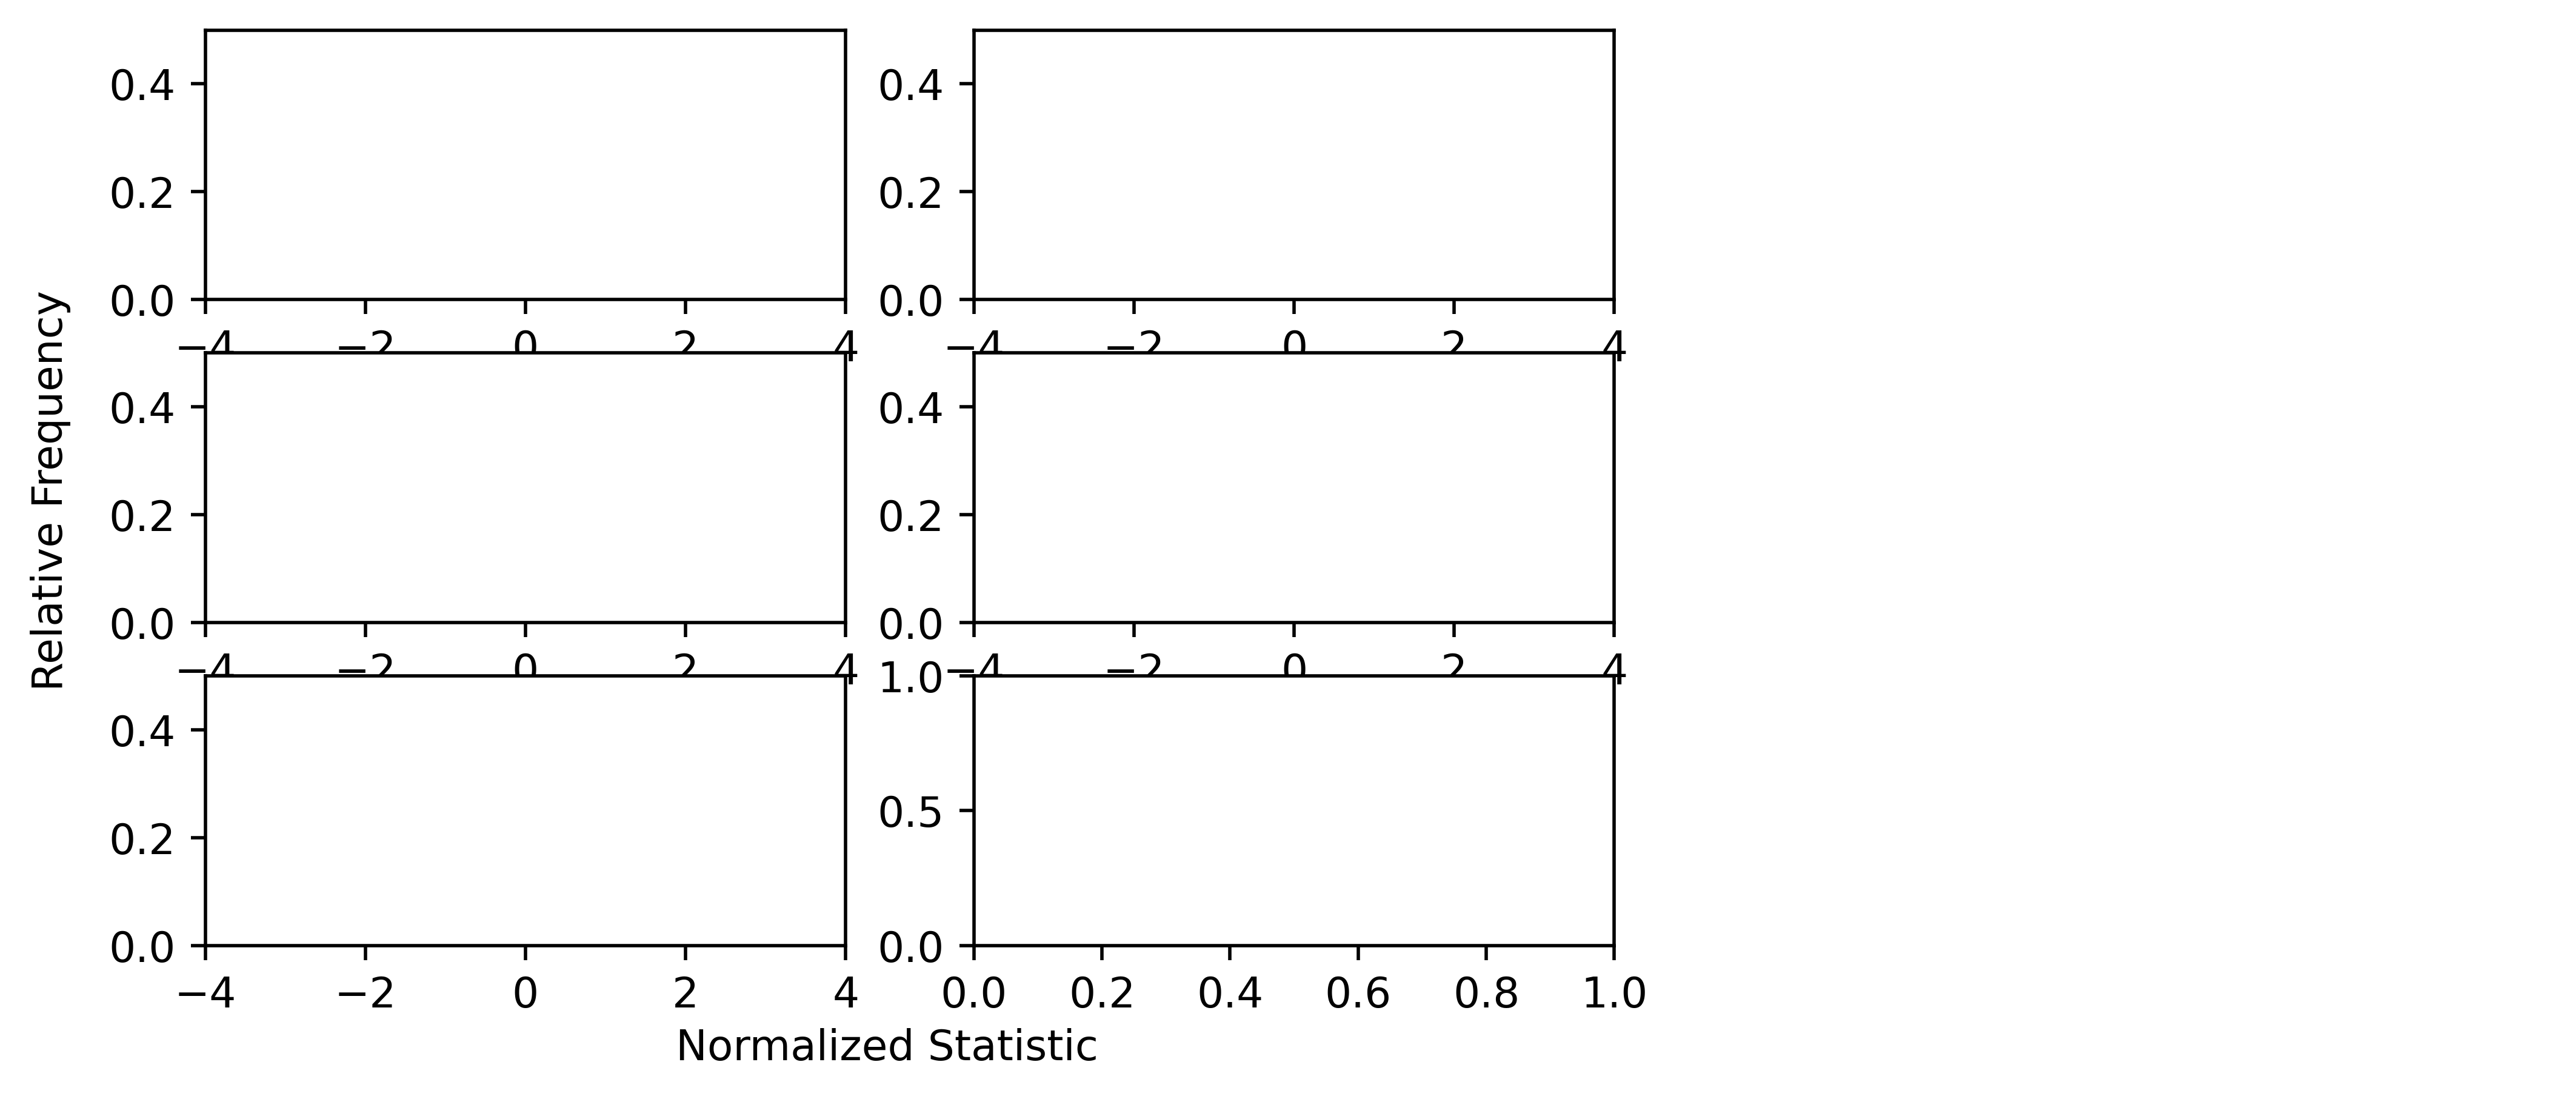

In [66]:
fig, ax = plt.subplots(nrows = 3, ncols = 2)
x = 0
y = 0

for i in range(0, np.shape(z_infs)[0]):

    sns.histplot(data= z_infs[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
    ax[x][y].set_xlim(-4, 4)
    ax[x][y].set_ylim(0, 0.5)
    
    ax[x][y].set(xlabel = '', ylabel = '')
    
    # Add custom note
    plt.annotate(f'Mean: {round(np.mean(z_infs[i]), 2)} \nVar: {round(np.std(z_infs[i]), 2)} \nN: {Ns[i]}', xy=(2, 0.8))
    #plt.show()
    
    if (i%2)==1:
        x+=1
        y = 0
    if (i%2)==0:
        y+=1
  
# fontsize=rcParams['axes.labelsize']
fig.text(0.5, 0.04, 'Normalized Statistic', va='center', ha='center', )
fig.text(0.04, 0.5, 'Relative Frequency', va='center', ha='center', rotation='vertical', )

#plt.tight_layout()
plt.show()

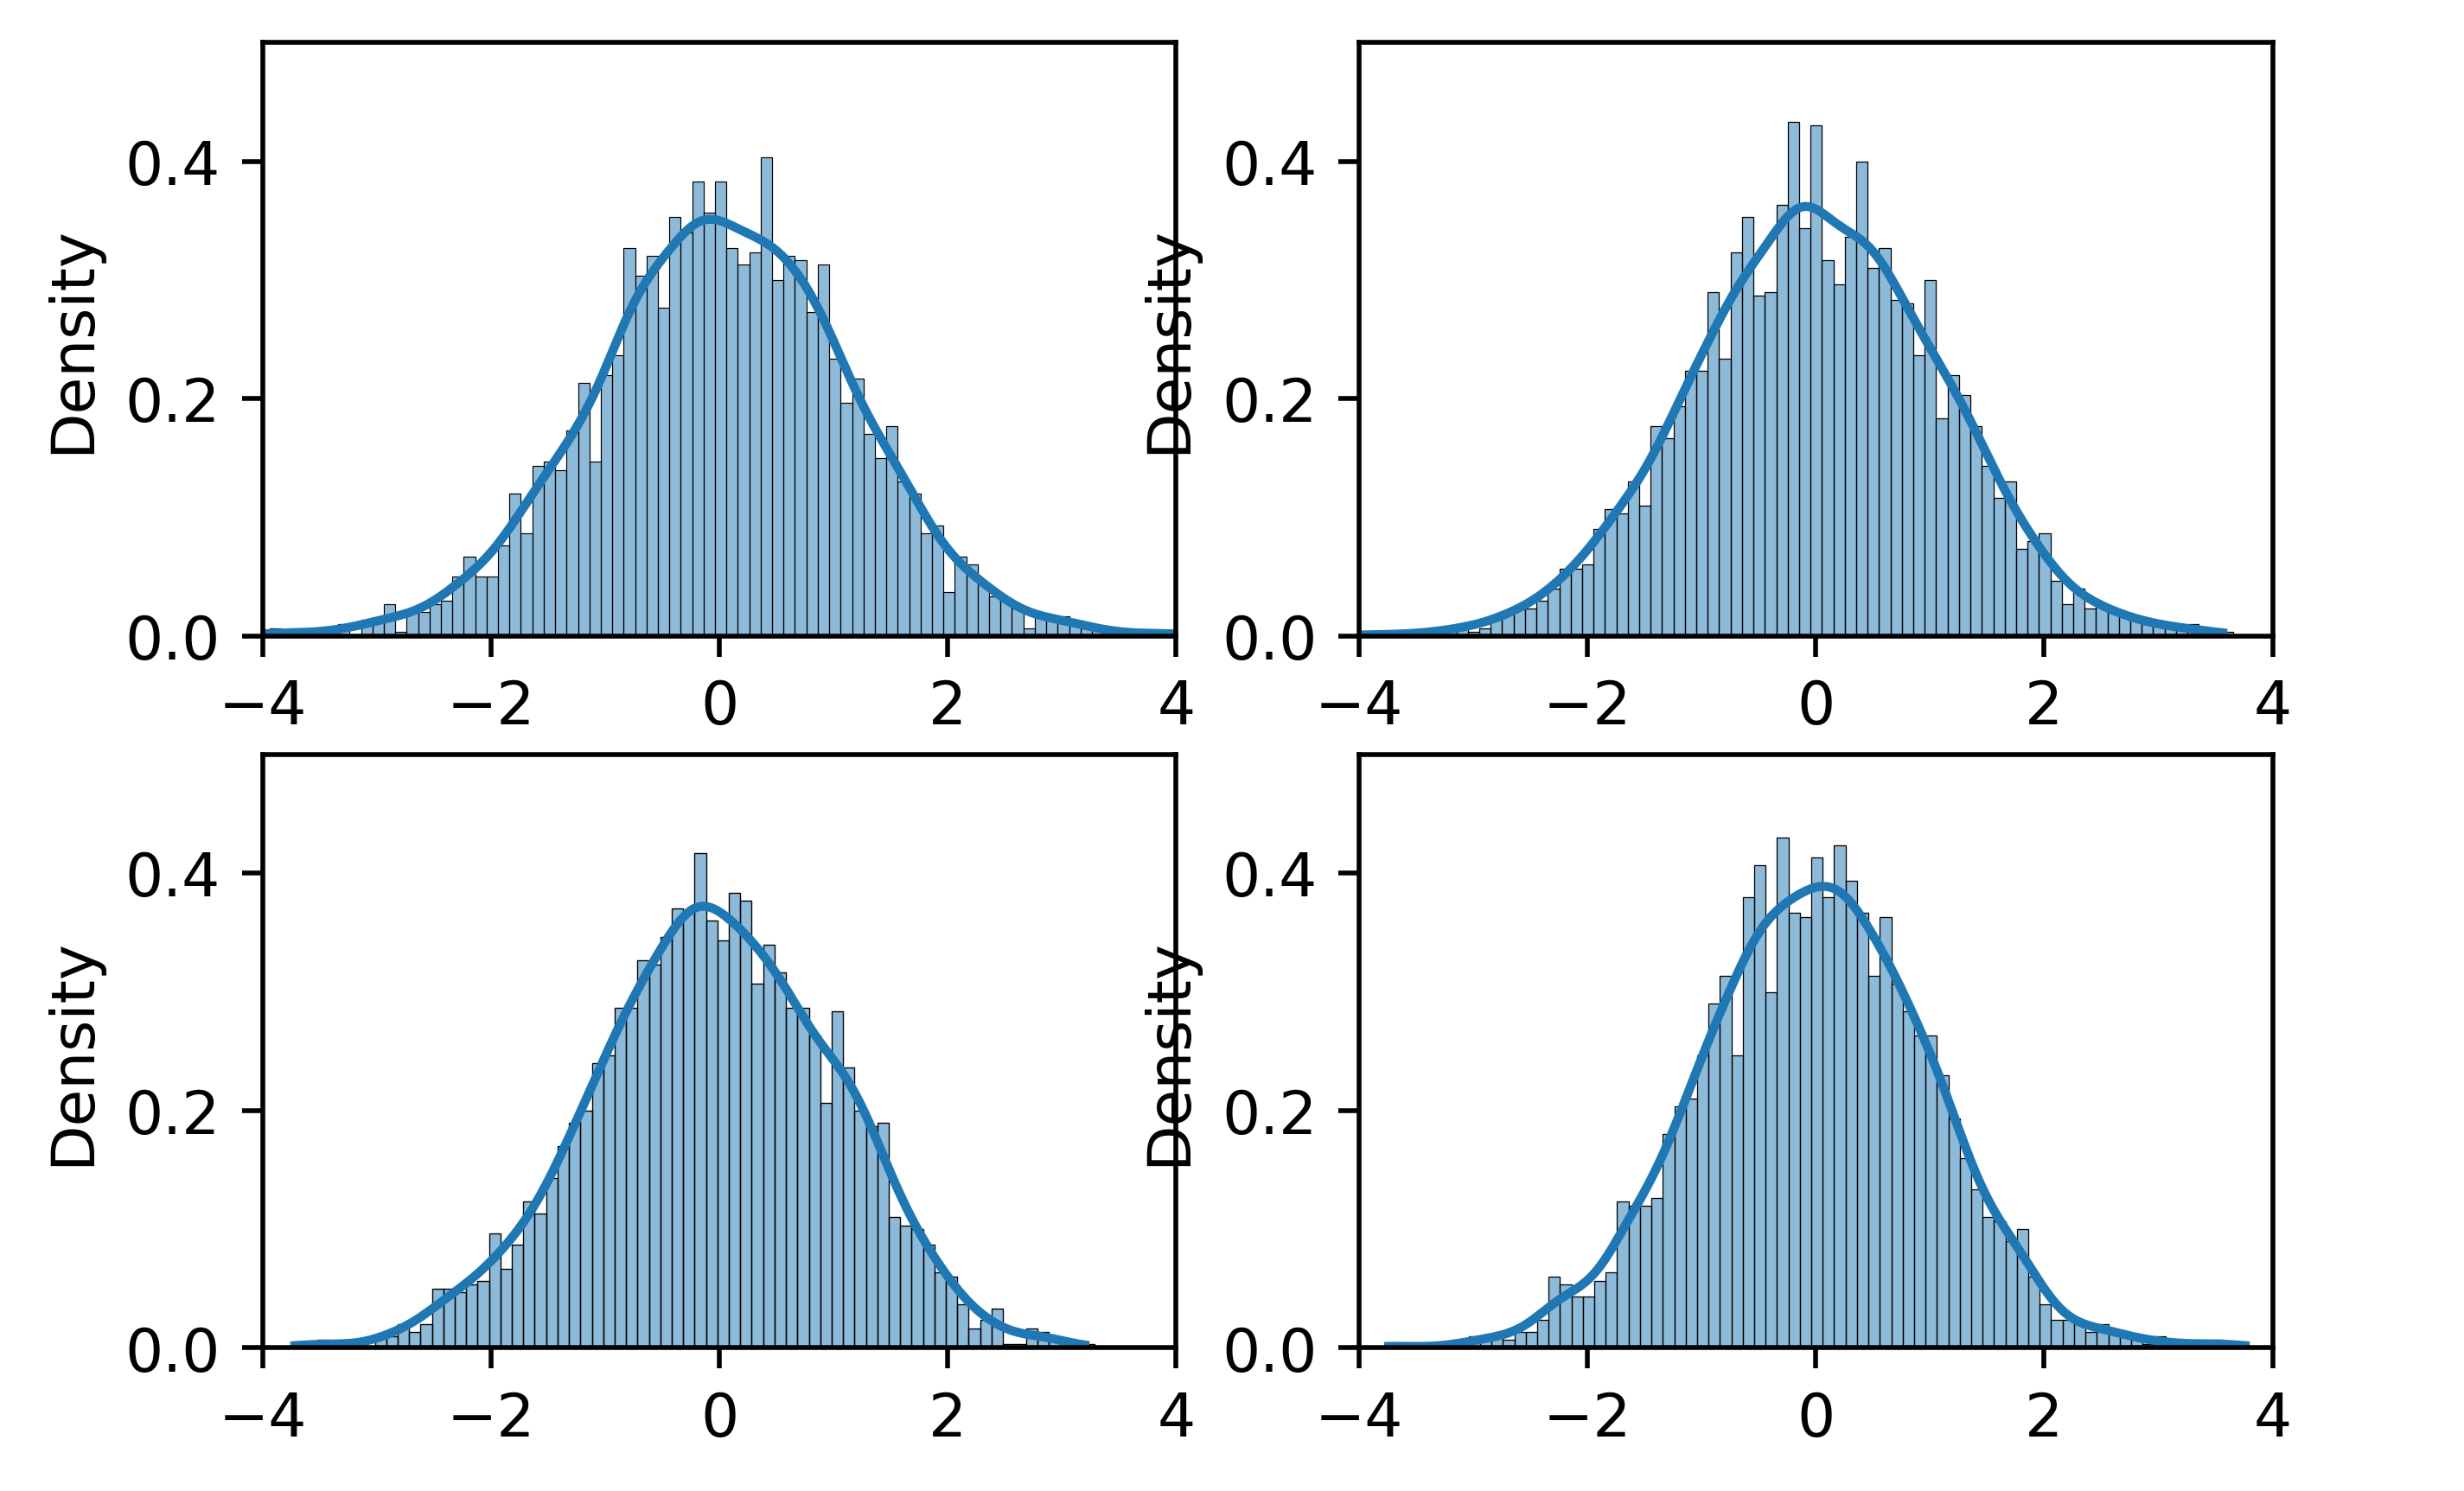

In [84]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
x = 0
y = 0

for i in range(0, np.shape(z_feas)[0]):

    sns.histplot(data= z_feas[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
    ax[x][y].set_xlim(-4, 4)
    ax[x][y].set_ylim(0, 0.5)
    
    # Add custom note
    plt.annotate(f'Mean: {round(np.mean(z_feas[i]), 2)} \nVar: {round(np.std(z_feas[i]), 2)} \nN: {Ns[i]}', xy=(2, 0.8))
    #plt.show()
    
    if (i%2)==1:
        x+=1
        y = 0
    if (i%2)==0:
        y+=1
        
      
# fontsize=rcParams['axes.labelsize']
fig.text(0.5, 0.04, 'Normalized Statistic', va='center', ha='center', )
fig.text(0.04, 0.5, 'Relative Frequency', va='center', ha='center', rotation='vertical', )

#plt.tight_layout()
plt.show()

\begin{eqnarray*}
 Z_{t}^{k(\sigma^2_f),inf} & := &  \sqrt{\frac{n}{\alpha_n} \frac{f_g^W((P_g^W)^{-1}(F(t)))^2}{(k'(\sigma_{t,f}^2) )^2f(t)}}(\widehat{k(\sigma_{t,f}^2)^n} - k(\sigma_{t,f}^2)),\\ 
Z_{t}^{k(\sigma^2_f),feas} & := &  \sqrt{\frac{n}{\alpha_n} \frac{f_g^W((P_g^W)^{-1}(\widehat{F}_n(t)))^2}{(\widehat{k'(\sigma_{t,f}^2)^n} )^2\widehat{f}_n(t)}}(\widehat{k(\sigma_{t,f}^2)^n} - k(\sigma_{t,f}^2)),
\end{eqnarray*}

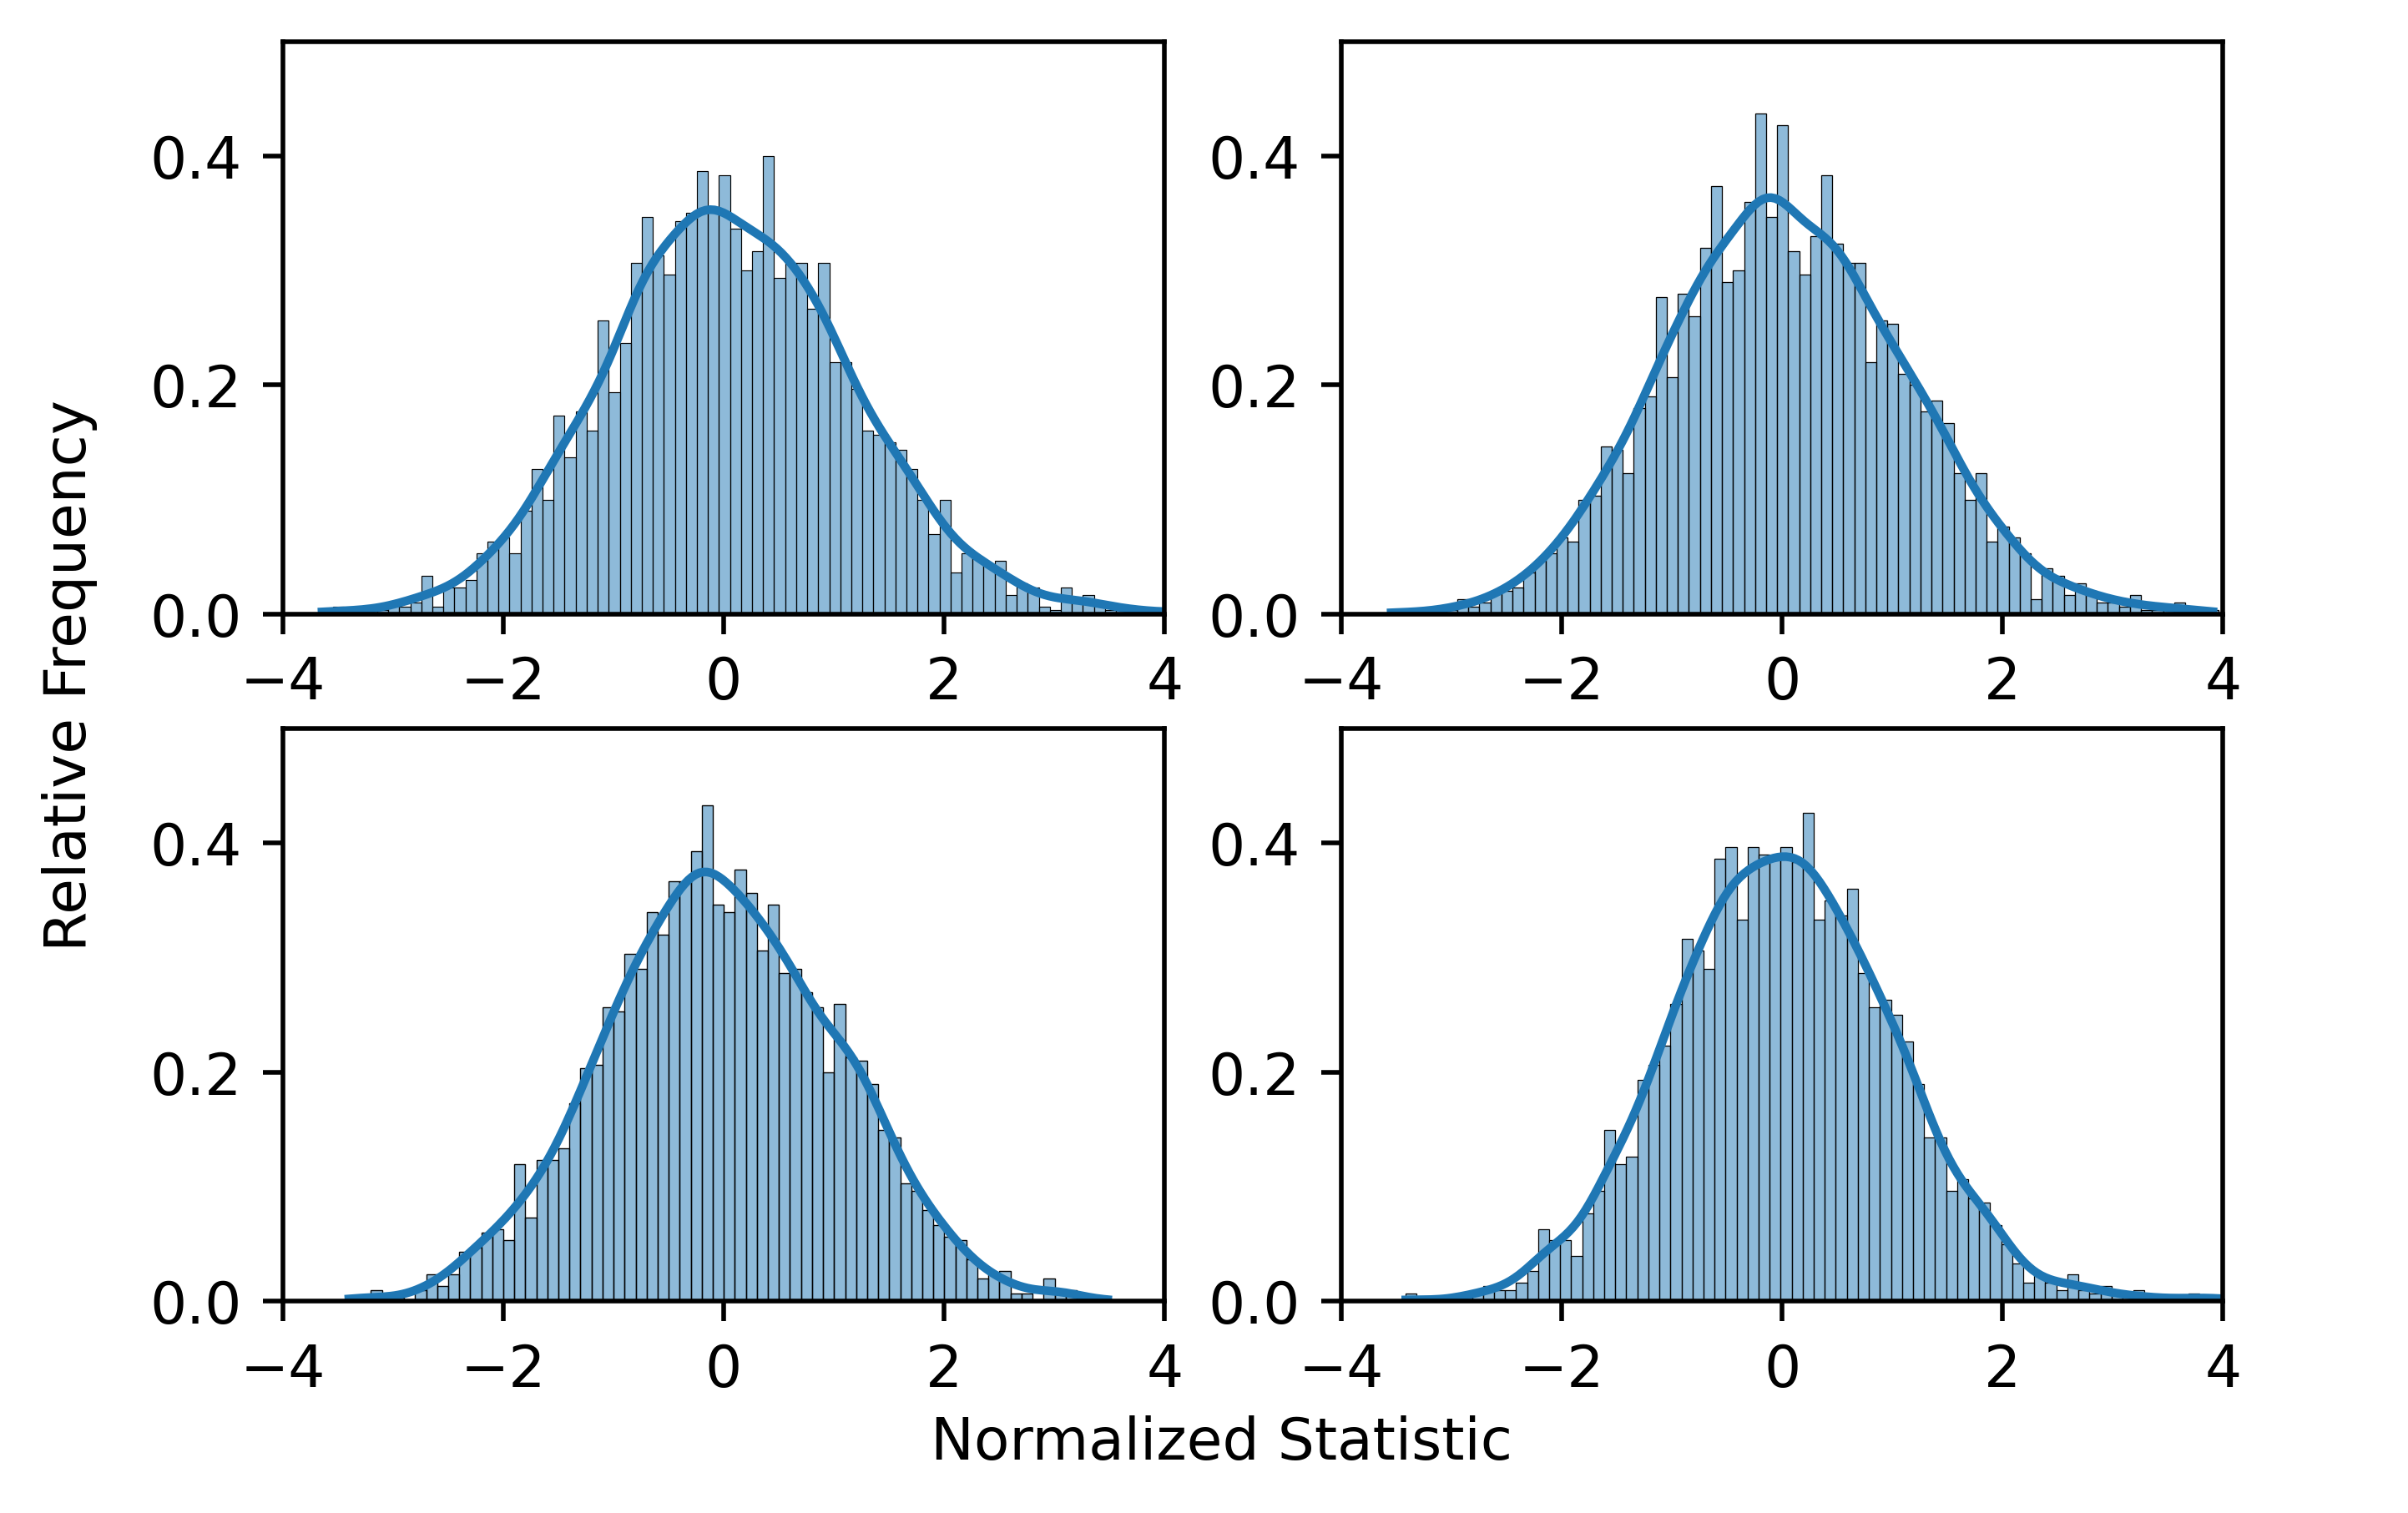

In [102]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
x = 0
y = 0

for i in range(0, np.shape(z_func_infs)[0]):

    sns.histplot(data= z_func_infs[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
    ax[x][y].set_xlim(-4, 4)
    ax[x][y].set_ylim(0, 0.5)
    
    ax[x][y].set(xlabel = '', ylabel = '')
    
    # Add custom note
    plt.annotate(f'Mean: {round(np.mean(z_func_infs[i]), 2)} \nVar: {round(np.std(z_func_infs[i]), 2)} \nN: {Ns[i]}', xy=(2, 0.8))
    #plt.show()
    
    if (i%2)==1:
        x+=1
        y = 0
    if (i%2)==0:
        y+=1
  
# fontsize=rcParams['axes.labelsize']
fig.text(0.5, 0.04, 'Normalized Statistic', va='center', ha='center', )
fig.text(0.04, 0.5, 'Relative Frequency', va='center', ha='center', rotation='vertical', )

#plt.tight_layout()
plt.show()

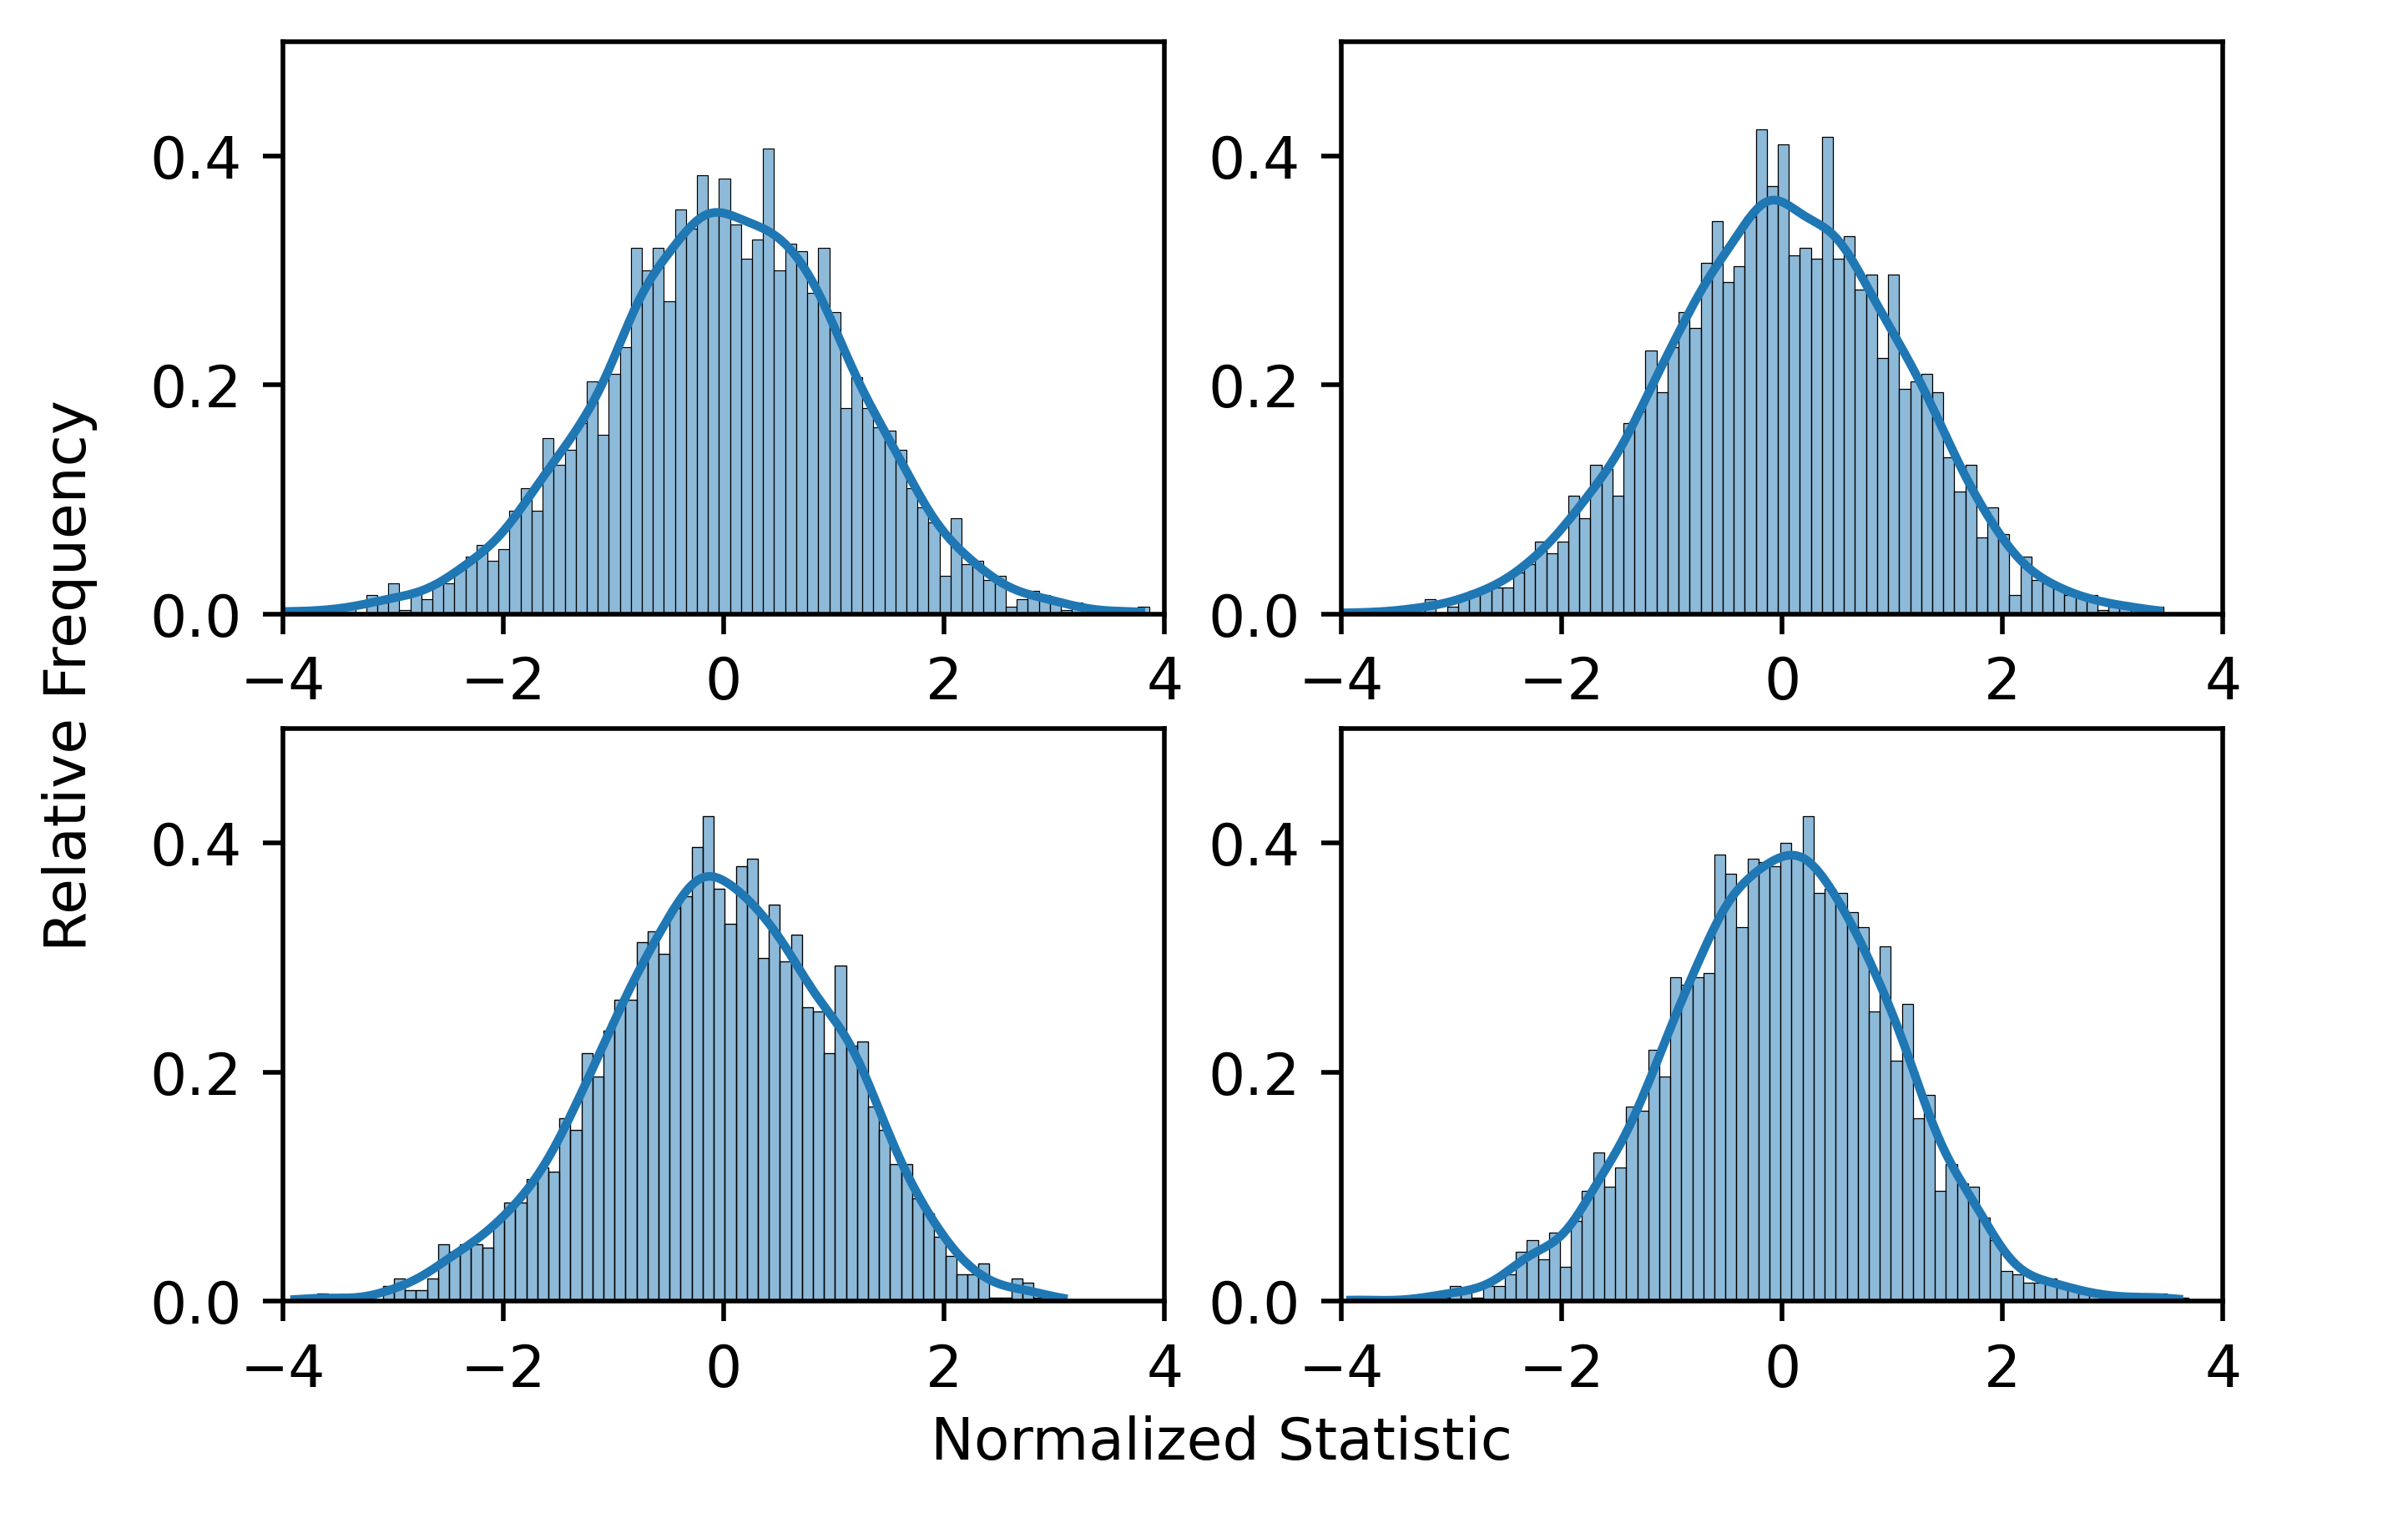

In [103]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
x = 0
y = 0

for i in range(0, np.shape(z_func_feas)[0]):

    sns.histplot(data= z_func_feas[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
    ax[x][y].set_xlim(-4, 4)
    ax[x][y].set_ylim(0, 0.5)
    
    ax[x][y].set(xlabel = '', ylabel = '')
    
    # Add custom note
    plt.annotate(f'Mean: {round(np.mean(z_func_feas[i]), 2)} \nVar: {round(np.std(z_func_feas[i]), 2)} \nN: {Ns[i]}', xy=(2, 0.8))
    #plt.show()
    
    if (i%2)==1:
        x+=1
        y = 0
    if (i%2)==0:
        y+=1
  
# fontsize=rcParams['axes.labelsize']
fig.text(0.5, 0.04, 'Normalized Statistic', va='center', ha='center', )
fig.text(0.04, 0.5, 'Relative Frequency', va='center', ha='center', rotation='vertical', )

#plt.tight_layout()
plt.show()

$\begin{eqnarray*}
  Z_{T_-,T_+}^{CV,inf} & := & \sqrt{\frac{n}{\alpha_n} \Big( \sum_{k=0}^{M_n-1} \frac{(k'(\sigma_{T_k^n,f}^2) )^2 f(T_k^n)}{f_g^W((P_g^W)^{-1}(F(T_k^n)))^2} \Delta_n \Big)^{-1}}(\widehat{CV}_g^n - CV_g),\\
   Z_{T_-,T_+}^{CV,feas} & := & \sqrt{\frac{n}{\alpha_n} \Big( \sum_{k=0}^{M_n-1} \frac{(\widehat{k'(\sigma_{T_k^n,f}^2)^n} )^2 \widehat{f}_n(T_k^n)}{f_g^W((P_g^W)^{-1}(\widehat{F}_n(T_k^n)))^2} \Delta_n \Big)^{-1}}(\widehat{CV}_g^n - CV_g).
\end{eqnarray*}$

In [ ]:
plt.hist(z_cv_infs,  label = "$Z_{T_-,T_+}^{CV,inf}$", alpha = 0.5)
plt.axvline(np.mean(z_cv_infs), linewidth = 1)

plt.hist(z_cv_feas,  label = "$Z_{T_-,T_+}^{CV,feas}$", alpha = 0.5)
plt.axvline(np.mean(z_cv_feas), linewidth = 1, color = 'orange', linestyle = 'dashed')

plt.legend()
plt.savefig('figures/levy/cv_z_stats', facecolor='w')

plt.show()

## All of them in 1 Big Plot

#### Normal

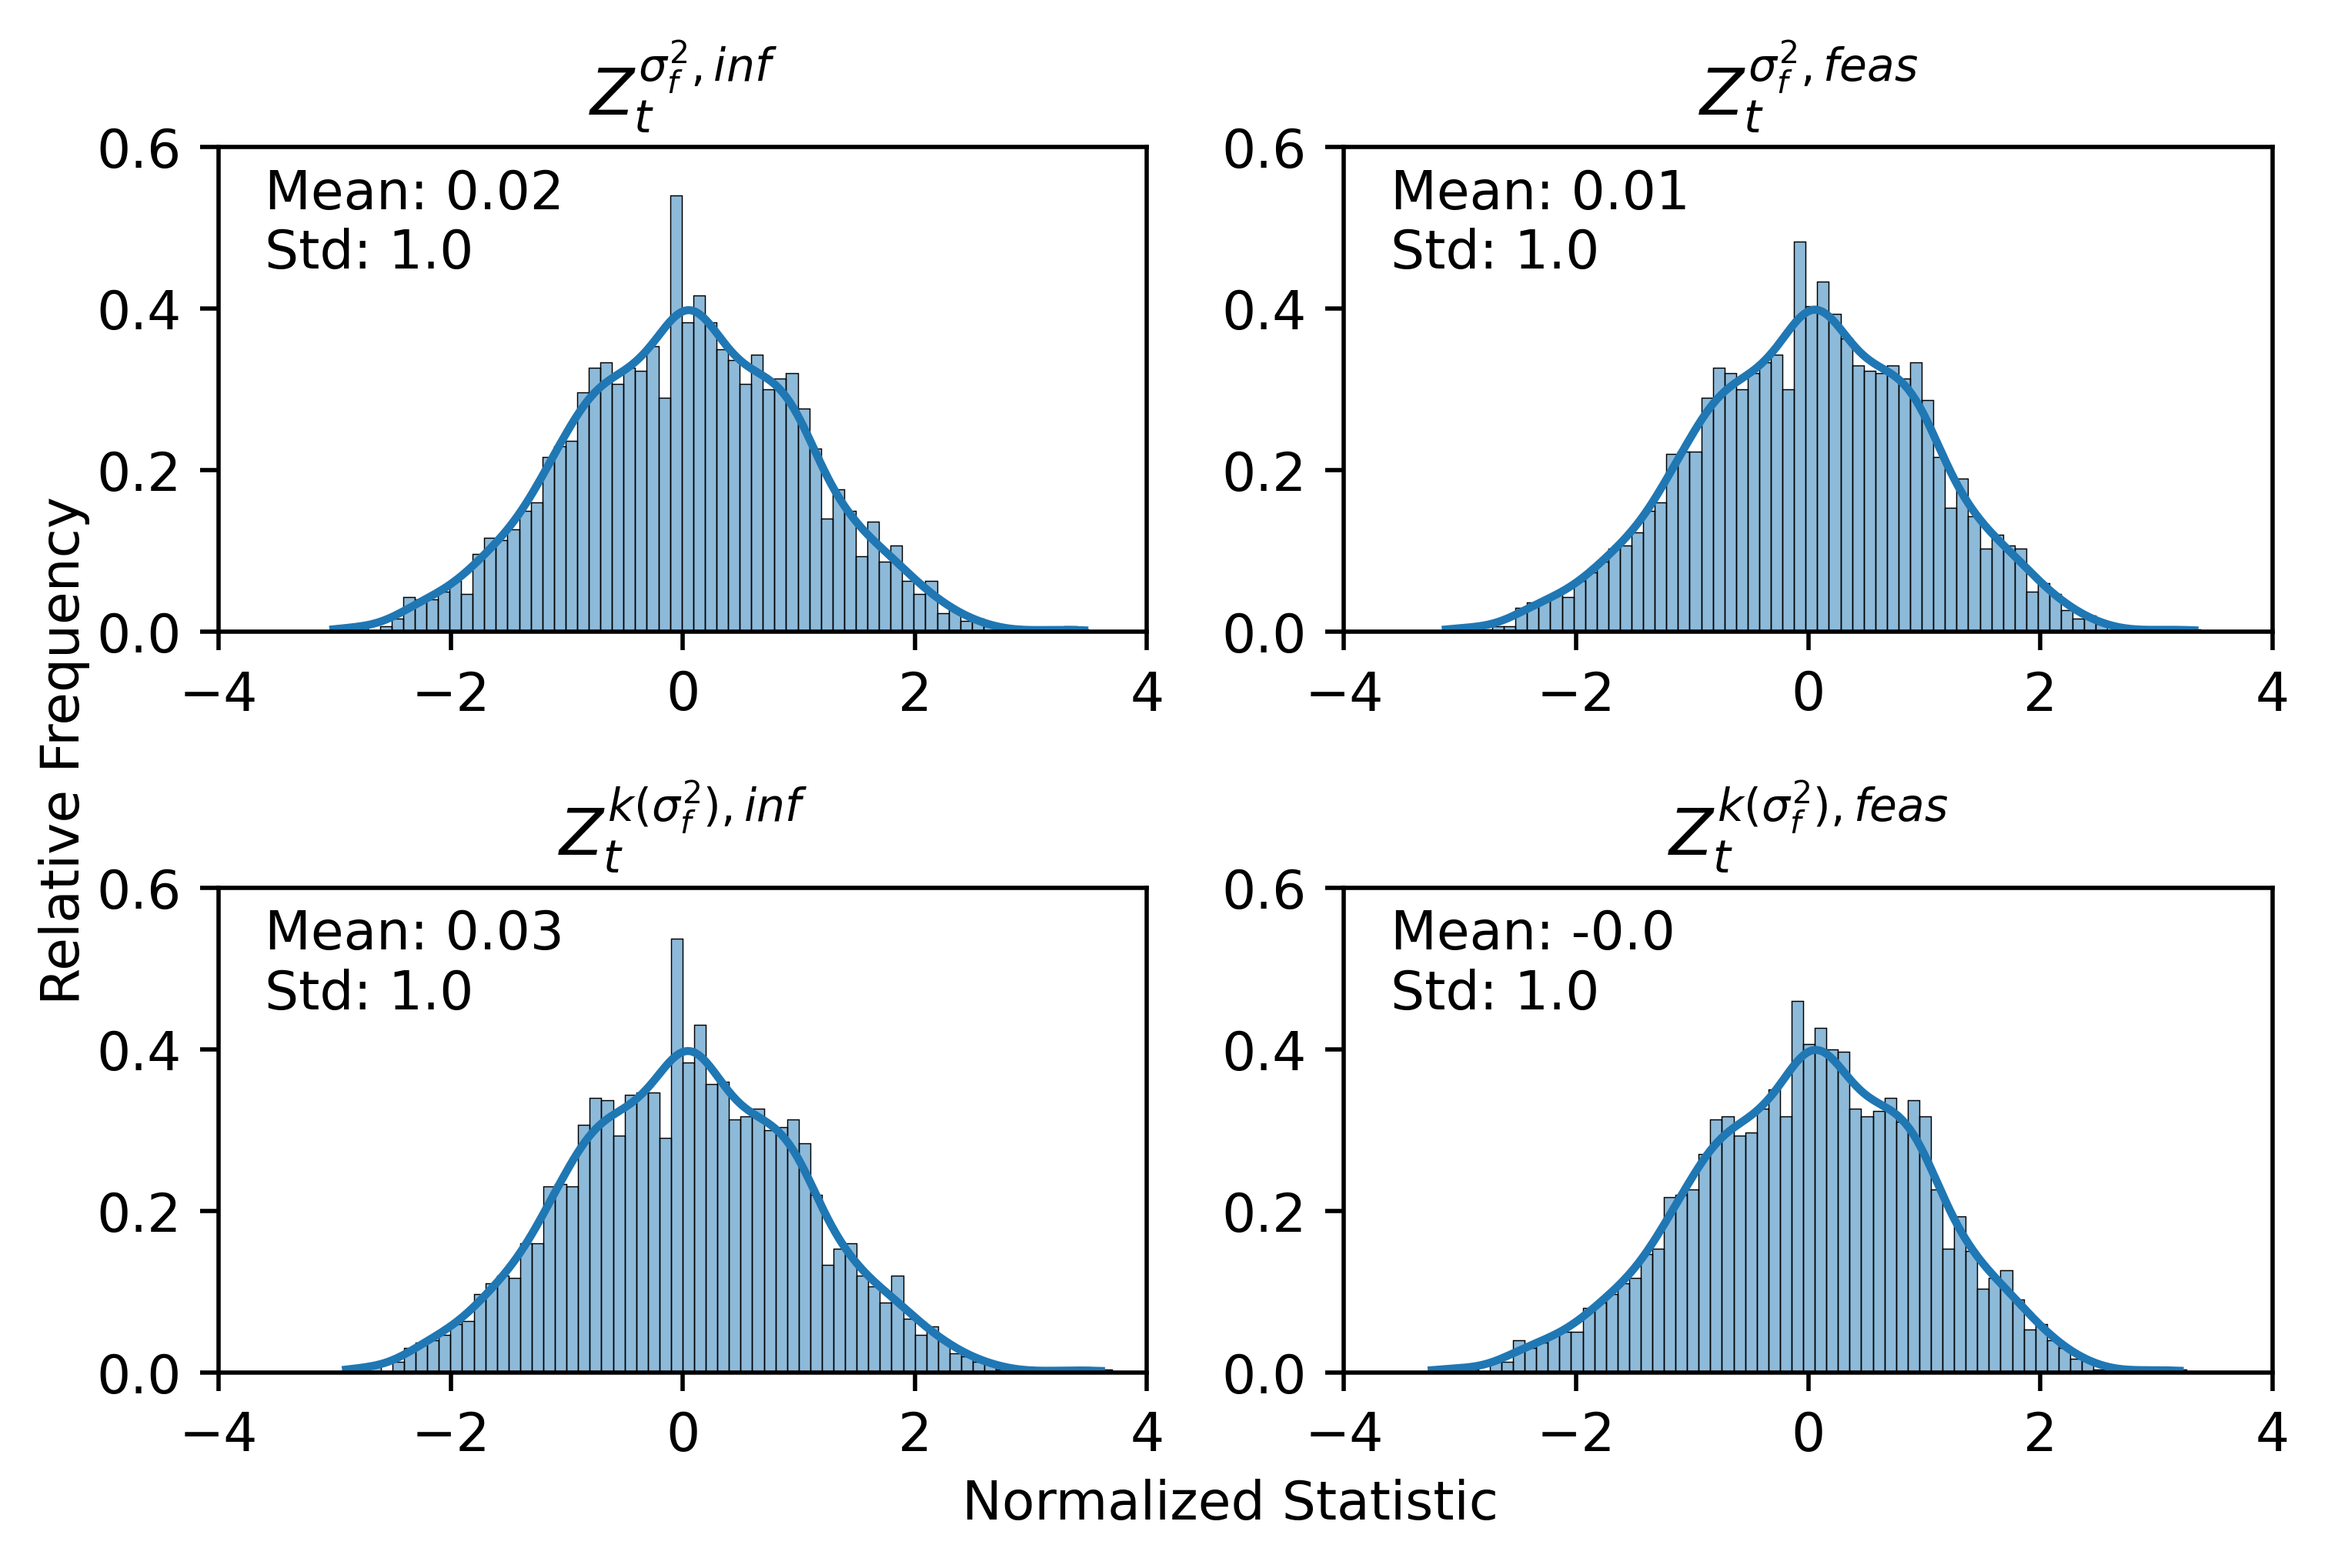

In [327]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
x = 0
y = 0
i = len(z_infs) - 1

### Basic
# inf
sns.histplot(data = z_infs[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
ax[x][y].set_xlim(-4, 4)
ax[x][y].set_ylim(0, 0.6)
    
ax[x][y].set(xlabel = '', ylabel = '')
ax[x][y].set_title('$Z_{t}^{\sigma^2_f,inf}$')

ax[x][y].annotate(f'Mean: {round(np.mean(z_infs[i]), 2)} \nStd: {round(np.std(z_infs[i]), 2)}', (0.05, 0.75), xycoords='axes fraction')


# feas
y += 1
sns.histplot(data= z_feas[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
ax[x][y].set_xlim(-4, 4)
ax[x][y].set_ylim(0, 0.6)
    
ax[x][y].set(xlabel = '', ylabel = '')
ax[x][y].set_title('$Z_{t}^{\sigma^2_f,feas}$')

ax[x][y].annotate(f'Mean: {round(np.mean(z_feas[i]), 2)} \nStd: {round(np.std(z_feas[i]), 2)}', (0.05, 0.75), xycoords='axes fraction')



### Functional
# inf
x = 1
y = 0
sns.histplot(data= z_func_infs[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
ax[x][y].set_xlim(-4, 4)
ax[x][y].set_ylim(0, 0.6)
    
ax[x][y].set(xlabel = '', ylabel = '')
ax[x][y].set_title('$Z_{t}^{k(\sigma^2_f),inf}$')

ax[x][y].annotate(f'Mean: {round(np.mean(z_func_infs[i]), 2)} \nStd: {round(np.std(z_func_infs[i]), 2)}', (0.05, 0.75), xycoords='axes fraction')



# feas
y += 1
sns.histplot(data= z_func_feas[i], kde=True,
                stat = 'density',
                binwidth = 0.1,
                ax = ax[x][y]
                )
ax[x][y].set_xlim(-4, 4)
ax[x][y].set_ylim(0, 0.6)
    
ax[x][y].set(xlabel = '', ylabel = '')
ax[x][y].set_title('$Z_{t}^{k(\sigma^2_f),feas}$')

ax[x][y].annotate(f'Mean: {round(np.mean(z_func_feas[i]), 2)} \nStd: {round(np.std(z_func_feas[i]), 2)}', (0.05, 0.75), xycoords='axes fraction')


### Cumulative functional

    
# Add custom note
#plt.annotate(f'Mean: {round(np.mean(z_infs[i]), 2)} \nVar: {round(np.std(z_infs[i]), 2)} \nN: {Ns[i]}', xy=(2, 0.8))
fig.text(0.4, 0.01, 'Normalized Statistic', va='center')
fig.text(0.00, 0.5, 'Relative Frequency', va='center', rotation='vertical')

plt.tight_layout()


plt.savefig('figures/levy/normalPlot.png', facecolor='w')
plt.show()
plt.close()

#### Q-Q Plot

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)


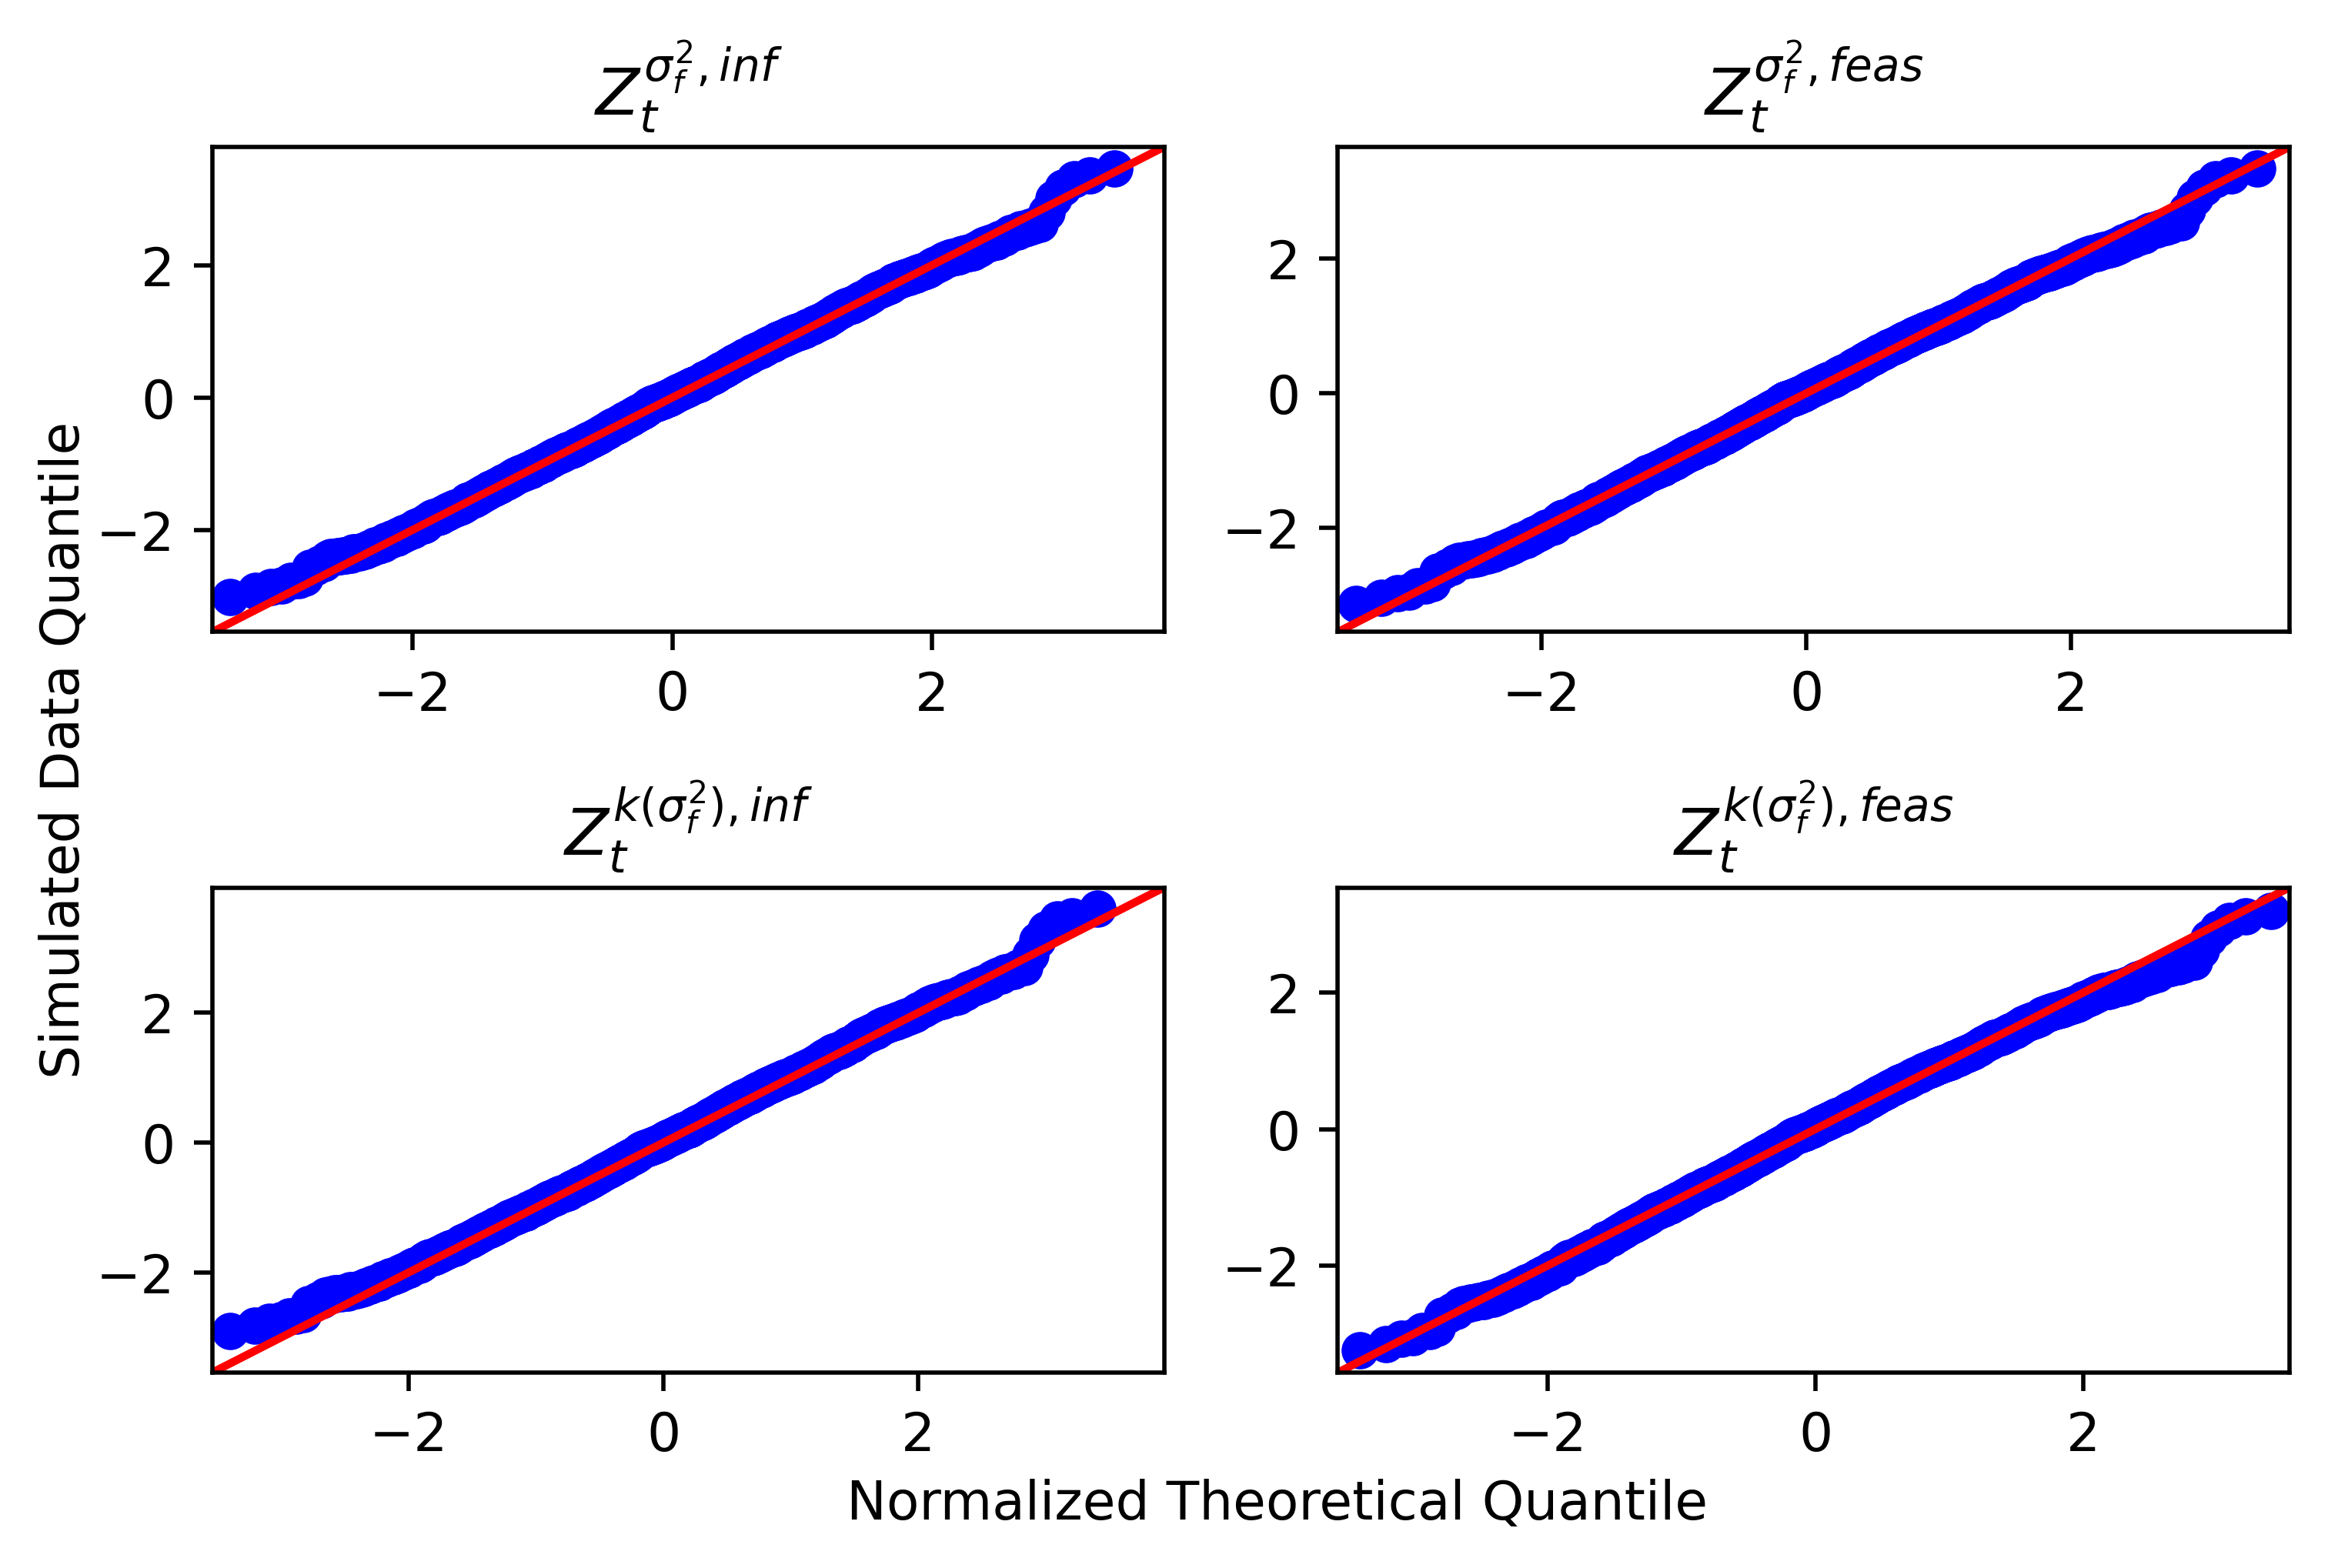

In [361]:
# figure
fig = plt.figure(facecolor='white')

# which one to rpoduce plots for
i = len(z_infs) - 1

### Basic
# inf
ax = fig.add_subplot(2,2,1)
sm.qqplot(z_infs[i], stats.norm,  loc=0, scale=1, line = '45', ax = ax)
ax.set(xlabel = '', ylabel = '')
ax.set_title('$Z_{t}^{\sigma^2_f,inf}$')


# feas
ax = fig.add_subplot(2,2,2)
sm.qqplot(z_feas[i], stats.norm,  loc=0, scale=1, line = '45', ax = ax)
ax.set(xlabel = '', ylabel = '')
ax.set_title('$Z_{t}^{\sigma^2_f,feas}$')


### Functional
# inf
ax = fig.add_subplot(2,2,3)
sm.qqplot(z_func_infs[i], stats.norm,  loc=0, scale=1, line = '45', ax = ax)
ax.set(xlabel = '', ylabel = '')
ax.set_title('$Z_{t}^{k(\sigma^2_f),inf}$')

# feas
ax = fig.add_subplot(2,2,4)
sm.qqplot(z_func_feas[i], stats.norm,  loc=0, scale=1, line = '45', ax = ax)
ax.set(xlabel = '', ylabel = '')
ax.set_title('$Z_{t}^{k(\sigma^2_f),feas}$')
    
# labels
fig.text(0.35, 0.01, 'Normalized Theoretical Quantile', va='center')
fig.text(0.00, 0.5, 'Simulated Data Quantile', va='center', rotation='vertical')

plt.tight_layout()

plt.savefig('figures/levy/qqPlot.png', facecolor='w')
plt.show()
plt.close()

In [ ]:
### 02/07/2024
# report a table with different n.
# 8 different ts,
# each table for different t 

# 2 points at the edge (not working as well)
# std, up to 1.5
# mean 10% deviation